In [1]:
from auditor import *

### User defined inputs ###

In [2]:
# Identify filenames for control, treatment and demographic information

control_ = "CRr1" #Raw text resume input
control_file = './Personality Prediction AI/data/'+control_+'.csv'

treatment_dict = {
                    'CRr2': 'Raw Text Resume 2',
                    'CRr3': 'Raw Text Resume 3',
                    'CRp1': 'PDF Resume',
                    'CL1': 'LinkedIn',
                    'CL2': 'LinkedIn'}

demographic_data_filename = "./Personality Prediction AI/data/survey.csv"

#Demographic information of interest:
groups_of_interest = {"gender": ["Female"], "race": ["White", "Asian"], "birth_country": ["India", "USA"]}

# Define the score_names (target labels) and the primary key between control, treatments and demographic information
score_names = ['Dominance', 'Influence', 'Steadiness', 'Conscientiousness']
primary_key = 'Participant_ID'

### Load the data: control and treatment inputs ###

In [3]:
control_input_df = pd.read_csv(control_file, index_col=primary_key)
control_input_df.head()

,Dominance,Influence,Steadiness,Conscientiousness,output_success
Participant_ID,,,,,
ID2,0,11,6,83,True
ID3,21,12,6,62,True
ID4,5,11,20,64,True
ID5,5,10,20,65,True
ID6,0,13,1,86,True


In [4]:
treatment_input = {}
for treatment_ in treatment_dict.keys():
    treatment_file = './Personality Prediction AI/data/'+treatment_+'.csv'
    treatment_input[treatment_dict[treatment_]] = pd.read_csv(treatment_file, index_col=primary_key)

### Load demographic data ###

In [5]:
demographic_df = pd.read_csv(demographic_data_filename, index_col=primary_key)

In [6]:
demographic_df.head()

,gender,race,birth_country,primary_language,resume,linkedin,twitter,linkedin_in_orig_resume,orig_embed_type,orig_file_type
Participant_ID,,,,,,,,,,
ID2,Male,Asian,USA,English,True,True,False,True,Full url hyperlinked,pdf
ID3,Male,Asian,USA,English,True,True,False,False,NaN,pdf
ID4,Male,Asian,India,Other Language,True,True,True,False,NaN,pdf
ID5,Male,White,Other Country,English,True,True,False,True,Full url hyperlinked,docx
ID6,Male,White,USA,English,True,True,False,True,Full url hyperlinked,pdf


### Only retaining IDs that exist in the control and all treatments

In [7]:
# We cannot compare scores if IDs are missing across treatments

ID_ = []

for treatment in treatment_input.keys():
    ID_.append(set(set.intersection(set(control_input_df.index), set(treatment_input[treatment].index))))
    
ID_list = list(set.intersection(*ID_))

In [8]:
demographic_df = demographic_df.loc[ID_list]
control_input_df = control_input_df.loc[ID_list]

for treatment in treatment_input.keys():
    treatment_input[treatment] = treatment_input[treatment].loc[ID_list]

### Hit the ADS to get scores for control and treatments ###

In [9]:
ADS_blackbox = ADS(score_names, primary_key)

This is an example of an external audit -- we only have blackbox access to the ADS, so the score function we will use here is a simple look-up. The "feature" X here is simply the primary ID that identifies a record

In [10]:
control_scores = ADS_blackbox.score(X=ID_list, score_func=functools.partial(ADS_lookup, filename=control_file))
control_scores.head()

,Dominance,Influence,Steadiness,Conscientiousness
Participant_ID,,,,
ID62,12,6,60,22
ID53,11,6,60,23
ID64,4,9,29,58
ID29,10,5,56,29
ID13,5,10,25,60


In [11]:
treatment_scores = {}
for treatment_ in treatment_dict.keys():
    treatment_file = './Personality Prediction AI/data/'+treatment_+'.csv'
    treatment_scores[treatment_dict[treatment_]] = ADS_blackbox.score(X=ID_list, score_func=functools.partial(ADS_lookup, filename=treatment_file))

## Auditing the stability of the scores for different treatments ##

### Instantiate the Auditor class ###

In [12]:
stability_audit = Auditor(score_names, primary_key, control_scores, 
                          treatment_scores, demographic_df, groups_of_interest)

### Visualizing scores for control and treatment 

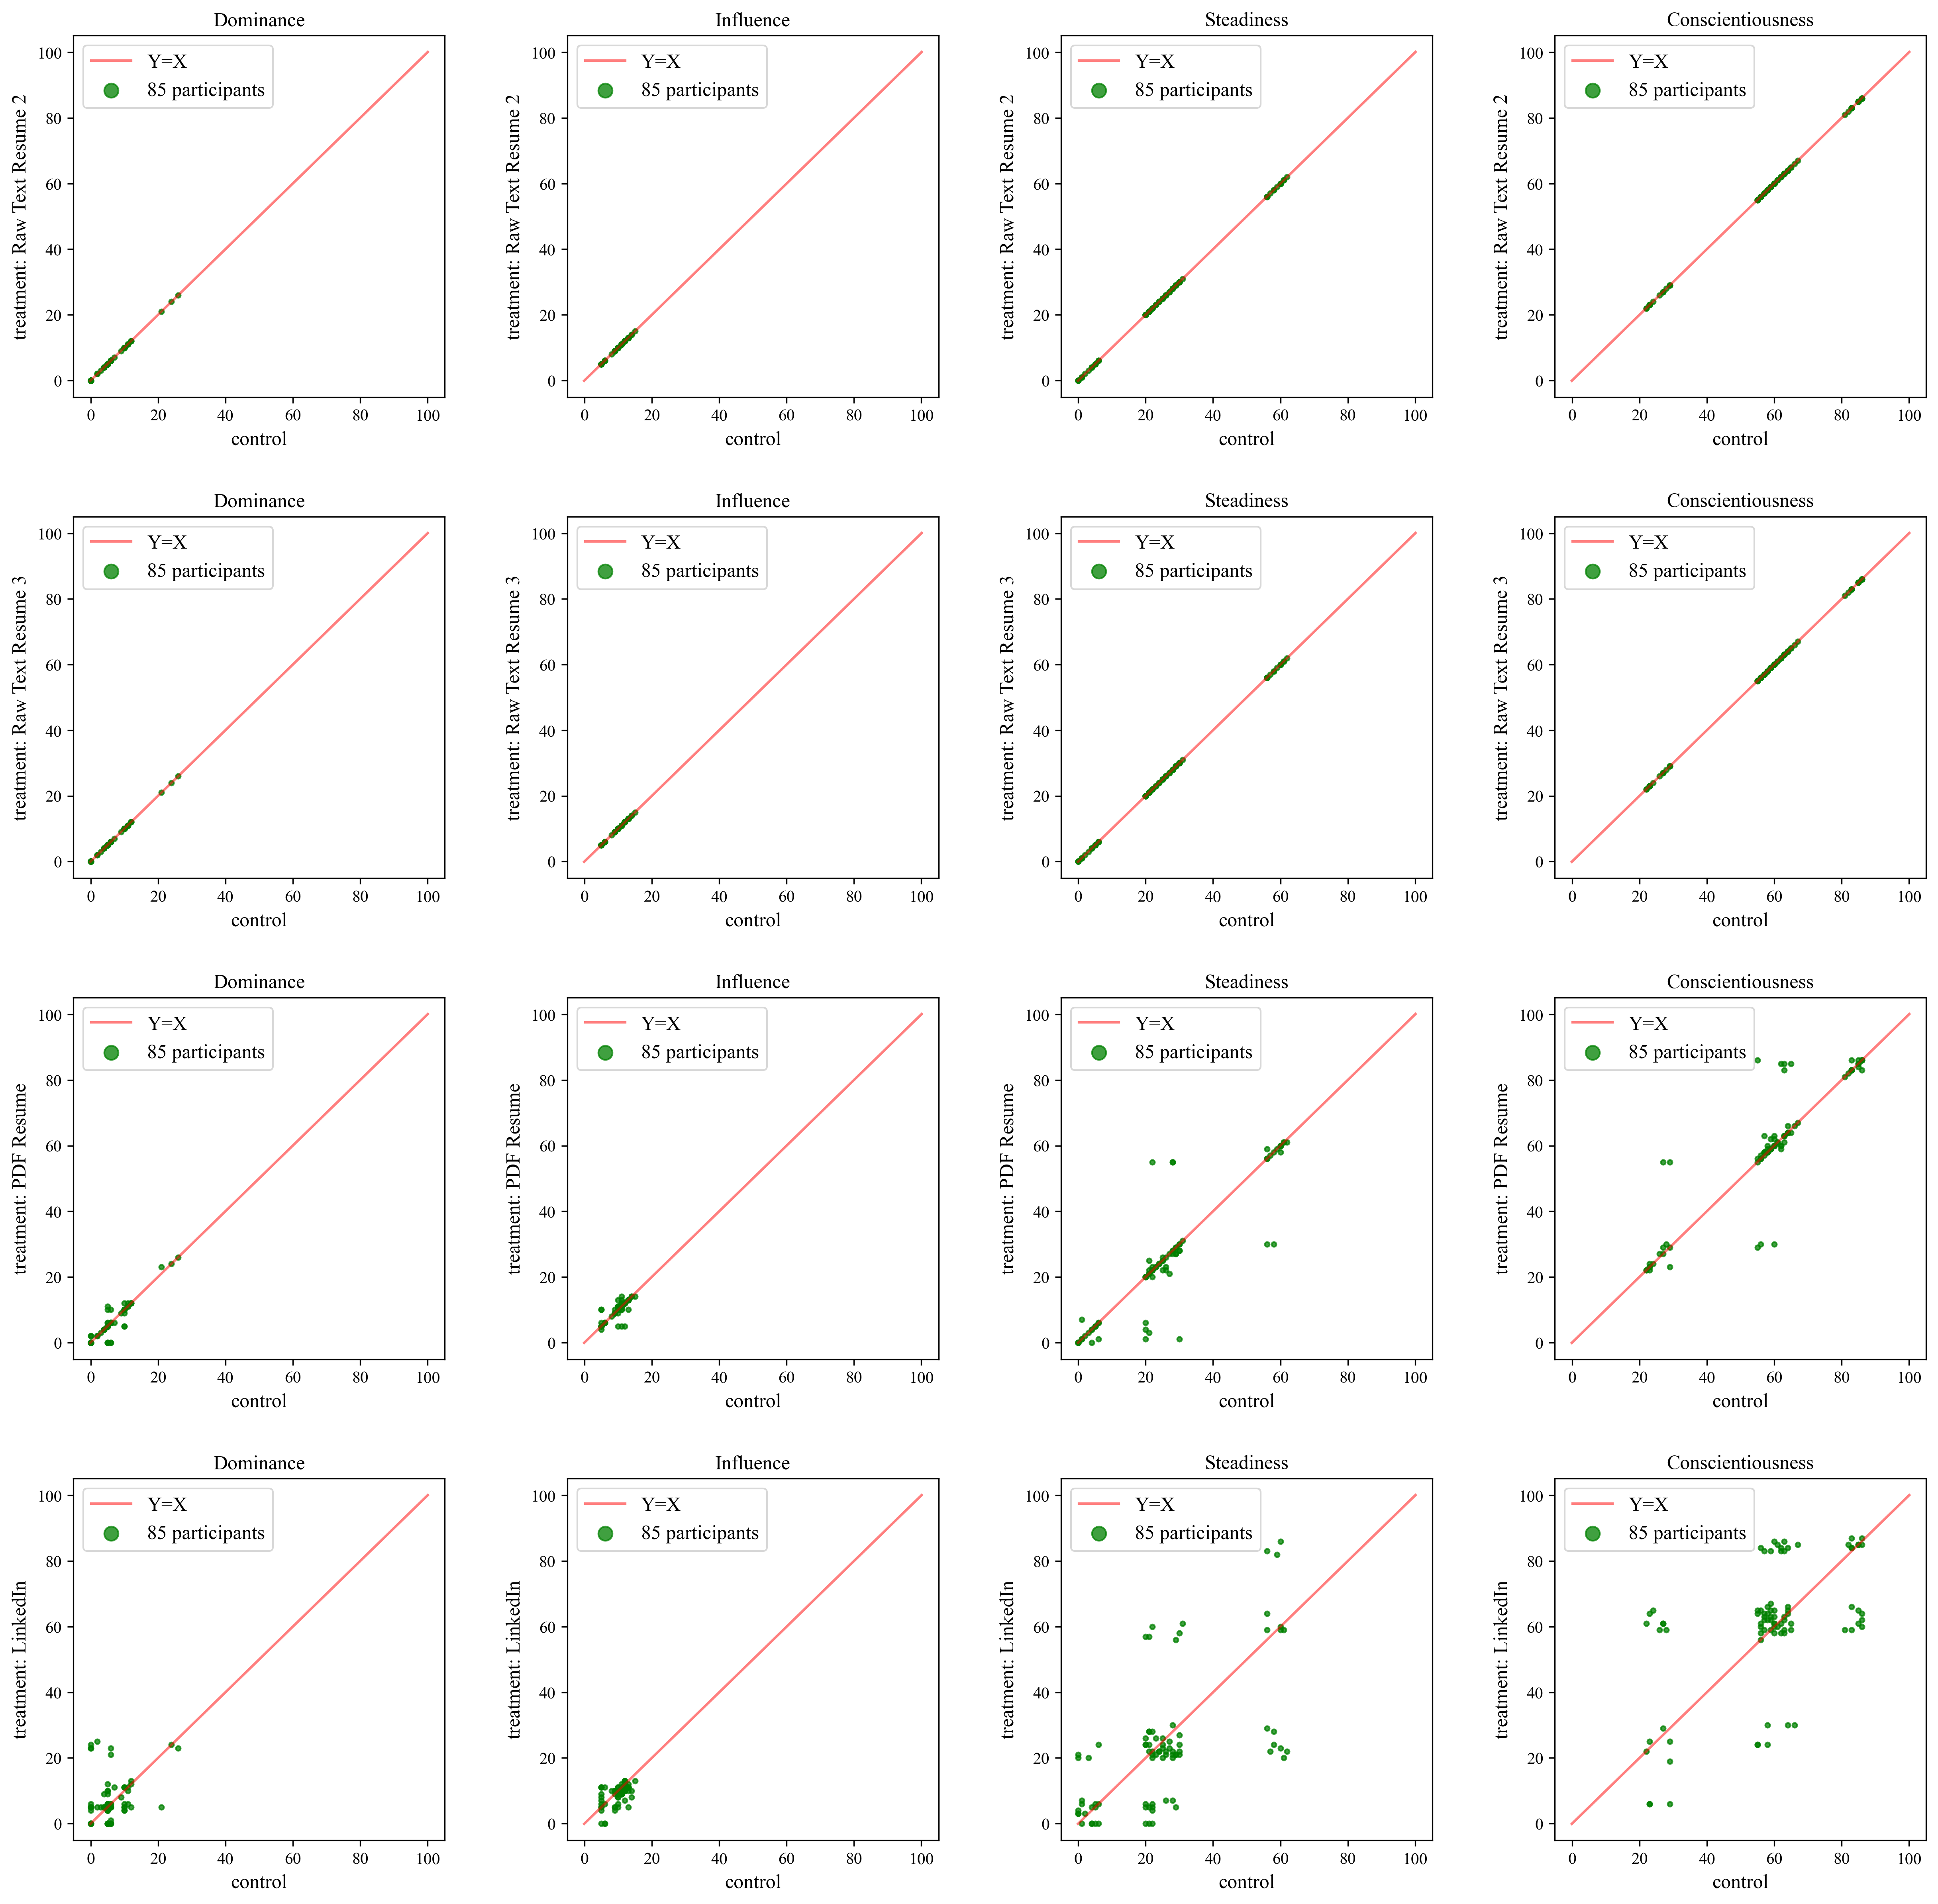

In [13]:
stability_audit.visualize_scores()

### Total change between control and treatment as a measure of stability ###

In [14]:
stability_audit.compute_total_variation()

Dominance  Influence  Steadiness  \
Raw Text Resume 2 overall__            mean   0.000000   0.000000    0.000000   
                                       std    0.000000   0.000000    0.000000   
                  gender_Female        mean   0.000000   0.000000    0.000000   
                                       std    0.000000   0.000000    0.000000   
                  gender_others        mean   0.000000   0.000000    0.000000   
...                                                ...        ...         ...   
LinkedIn          birth_country_India  std    3.281792   1.385408    9.079399   
                  birth_country_USA    mean   5.333333   1.916667   12.458333   
                                       std    7.275131   1.976309   12.514267   
                  birth_country_others mean   3.517241   2.413793   12.310345   
                                       std    5.754630   2.275918   14.207904   

                                             Conscientiousness  
Raw Text Resume 2 overall__            mean           0.000000  
                                       std            0.000000  
                  gender_Female        mean           0.000000  
                                       std            0.000000  
                  gender_others        mean           0.000000  
...                                                        ...  
LinkedIn          birth_country_India  std           10.615674  
                  birth_country_USA    mean          14.625000  
                                       std           13.515892  
                  birth_country_others mean          12.931034  
                                       std           13.946149  

[72 rows x 4 columns]

### Visualizing the total change (L1 norm)

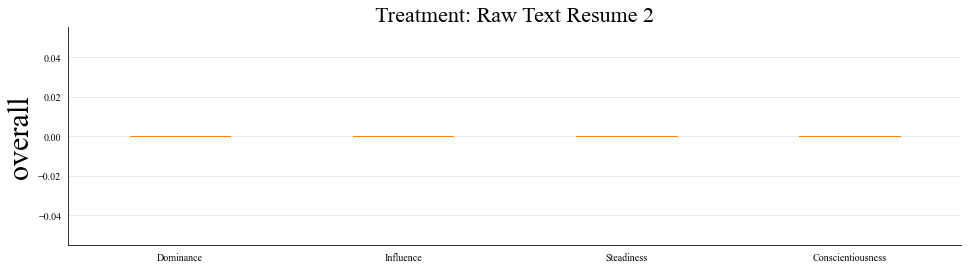

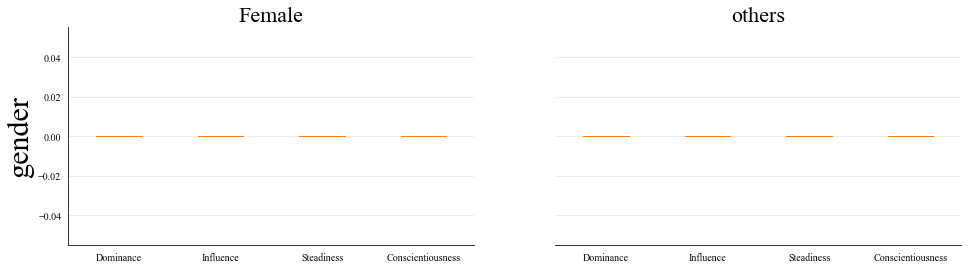

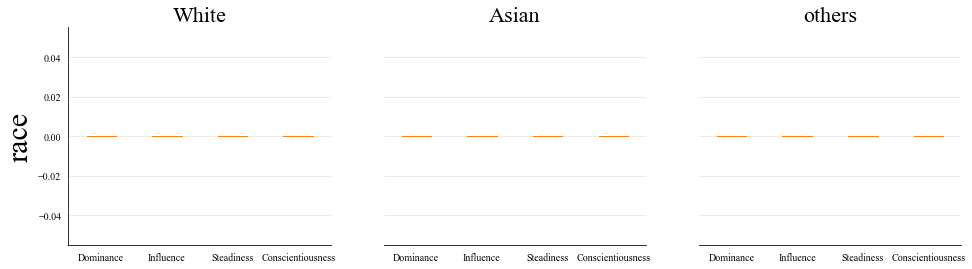

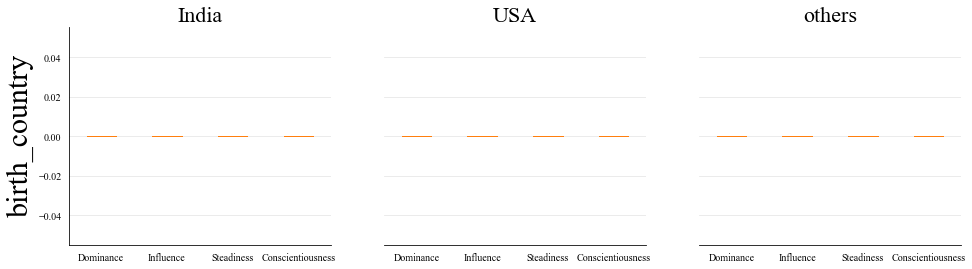

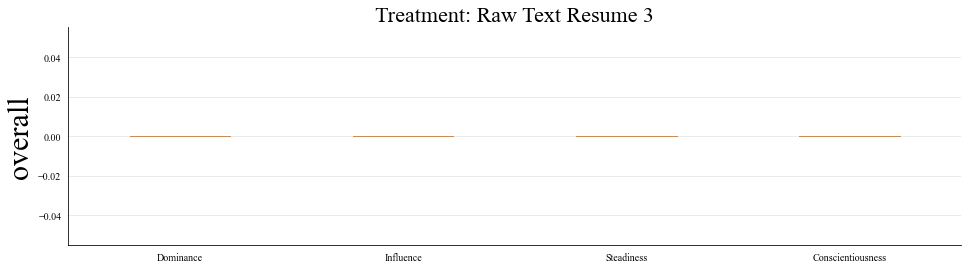

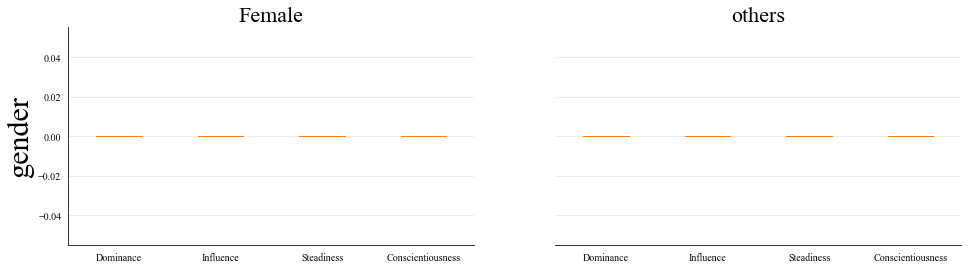

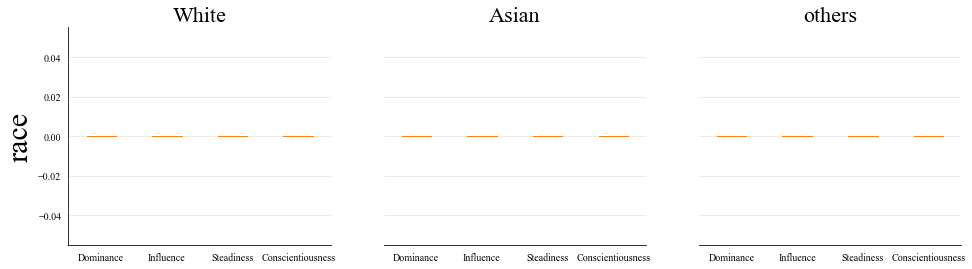

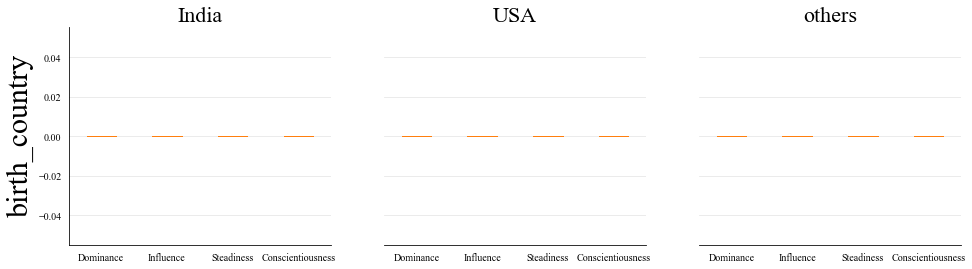

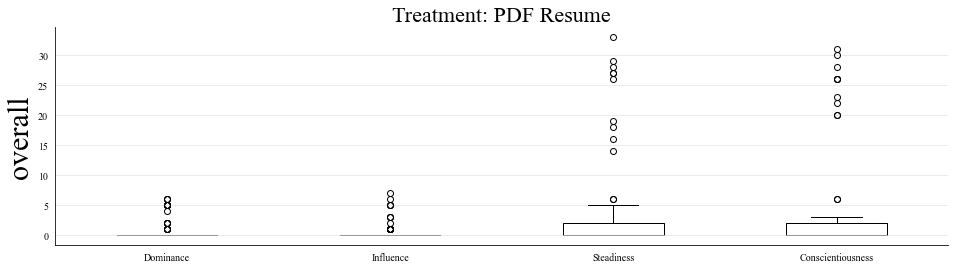

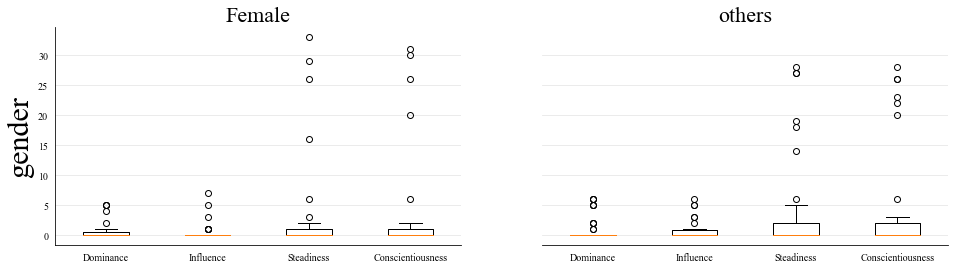

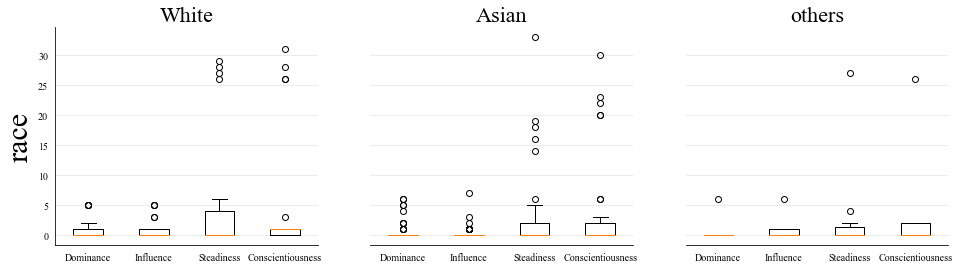

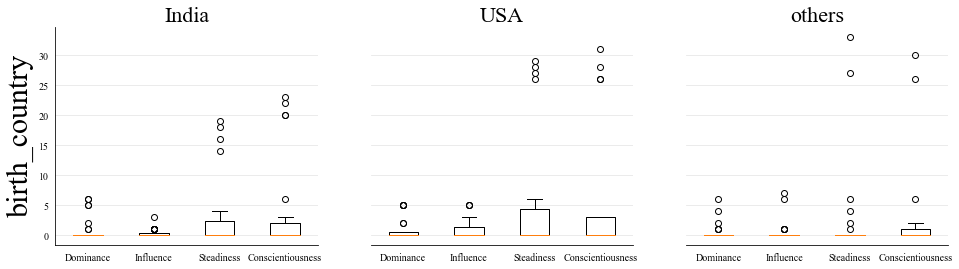

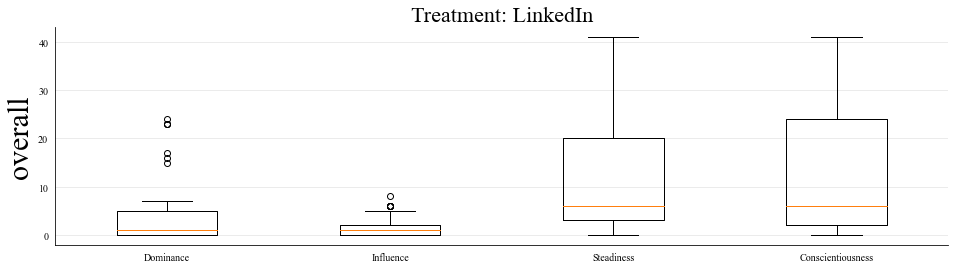

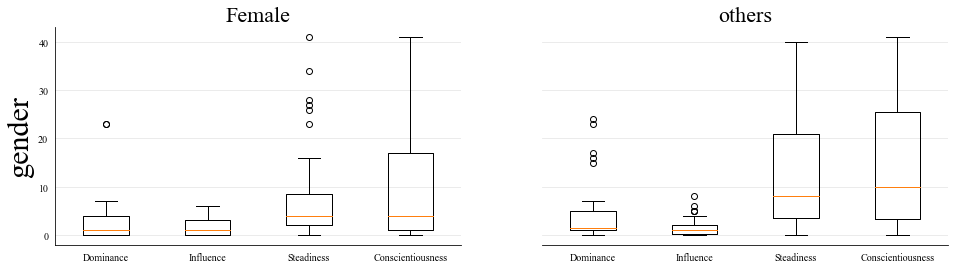

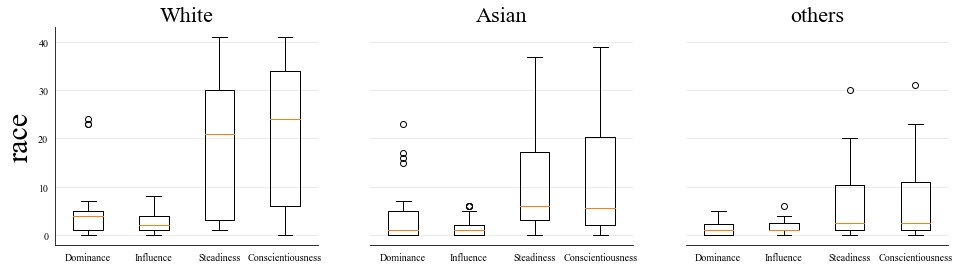

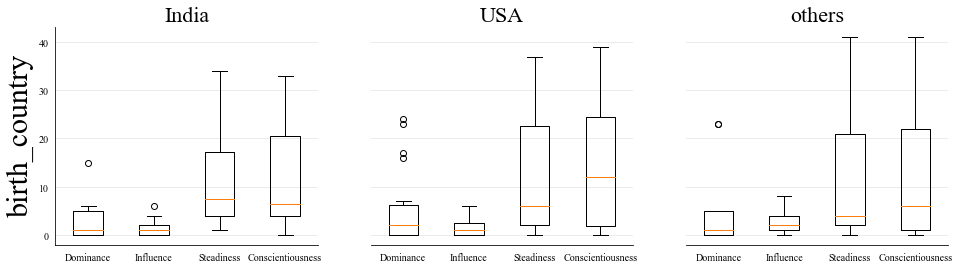

In [15]:
stability_audit.visualize_total_variation()

### Correlation between control and treatment as a measure of rank-order stability

In [16]:
spearman_ = stability_audit.compute_statistic(test=spearman)
spearman_

Dominance  Influence  \
Raw Text Resume 2 overall__            correlation   1.000000   1.000000   
                                       p_value       0.000000   0.000000   
                  gender_Female        correlation   1.000000   1.000000   
                                       p_value       0.000000   0.000000   
                  gender_others        correlation   1.000000   1.000000   
...                                                       ...        ...   
LinkedIn          birth_country_India  p_value       0.423499   0.005217   
                  birth_country_USA    correlation   0.181208   0.581939   
                                       p_value       0.396777   0.002853   
                  birth_country_others correlation   0.427346   0.500667   
                                       p_value       0.020763   0.005671   

                                                    Steadiness  \
Raw Text Resume 2 overall__            correlation    1.000000   
                                       p_value        0.000000   
                  gender_Female        correlation    1.000000   
                                       p_value        0.000000   
                  gender_others        correlation    1.000000   
...                                                        ...   
LinkedIn          birth_country_India  p_value        0.002236   
                  birth_country_USA    correlation    0.700612   
                                       p_value        0.000138   
                  birth_country_others correlation    0.593707   
                                       p_value        0.000686   

                                                    Conscientiousness  
Raw Text Resume 2 overall__            correlation           1.000000  
                                       p_value               0.000000  
                  gender_Female        correlation           1.000000  
                                       p_value               0.000000  
                  gender_others        correlation           1.000000  
...                                                               ...  
LinkedIn          birth_country_India  p_value               0.045087  
                  birth_country_USA    correlation           0.517265  
                                       p_value               0.009639  
                  birth_country_others correlation           0.513366  
                                       p_value               0.004398  

[72 rows x 4 columns]

In [17]:
# User defined threshold
corr_threshold = 0.9

In [18]:
# If correlation is greater than the threshold, ADS is stable for that treatment
spearman_.loc[[i for i in spearman_.index if 'correlation' in i]] >= corr_threshold

Dominance  Influence  \
Raw Text Resume 2 overall__            correlation       True       True   
                  gender_Female        correlation       True       True   
                  gender_others        correlation       True       True   
                  race_White           correlation       True       True   
                  race_Asian           correlation       True       True   
                  race_others          correlation       True       True   
                  birth_country_India  correlation       True       True   
                  birth_country_USA    correlation       True       True   
                  birth_country_others correlation       True       True   
Raw Text Resume 3 overall__            correlation       True       True   
                  gender_Female        correlation       True       True   
                  gender_others        correlation       True       True   
                  race_White           correlation       True       True   
                  race_Asian           correlation       True       True   
                  race_others          correlation       True       True   
                  birth_country_India  correlation       True       True   
                  birth_country_USA    correlation       True       True   
                  birth_country_others correlation       True       True   
PDF Resume        overall__            correlation      False      False   
                  gender_Female        correlation       True      False   
                  gender_others        correlation      False      False   
                  race_White           correlation      False      False   
                  race_Asian           correlation      False      False   
                  race_others          correlation       True      False   
                  birth_country_India  correlation      False       True   
                  birth_country_USA    correlation      False      False   
                  birth_country_others correlation       True      False   
LinkedIn          overall__            correlation      False      False   
                  gender_Female        correlation      False      False   
                  gender_others        correlation      False      False   
                  race_White           correlation      False      False   
                  race_Asian           correlation      False      False   
                  race_others          correlation      False      False   
                  birth_country_India  correlation      False      False   
                  birth_country_USA    correlation      False      False   
                  birth_country_others correlation      False      False   

                                                    Steadiness  \
Raw Text Resume 2 overall__            correlation        True   
                  gender_Female        correlation        True   
                  gender_others        correlation        True   
                  race_White           correlation        True   
                  race_Asian           correlation        True   
                  race_others          correlation        True   
                  birth_country_India  correlation        True   
                  birth_country_USA    correlation        True   
                  birth_country_others correlation        True   
Raw Text Resume 3 overall__            correlation        True   
                  gender_Female        correlation        True   
                  gender_others        correlation        True   
                  race_White           correlation        True   
                  race_Asian           correlation        True   
                  race_others          correlation        True   
                  birth_country_India  correlation        True   
                  birth_country_USA    correlation        True   
                  birth_country_others correlation 

### Wilcoxon signed rank test as a measure of locational stability

In [19]:
wilcoxon_ = stability_audit.compute_statistic(test=wilcoxon)

All differences are 0 for Dominance. Did not perform Wilcoxon signed rank test.
All differences are 0 for Influence. Did not perform Wilcoxon signed rank test.
All differences are 0 for Steadiness. Did not perform Wilcoxon signed rank test.
All differences are 0 for Conscientiousness. Did not perform Wilcoxon signed rank test.
All differences are 0 for Dominance. Did not perform Wilcoxon signed rank test.
All differences are 0 for Influence. Did not perform Wilcoxon signed rank test.
All differences are 0 for Steadiness. Did not perform Wilcoxon signed rank test.
All differences are 0 for Conscientiousness. Did not perform Wilcoxon signed rank test.
All differences are 0 for Dominance. Did not perform Wilcoxon signed rank test.
All differences are 0 for Influence. Did not perform Wilcoxon signed rank test.
All differences are 0 for Steadiness. Did not perform Wilcoxon signed rank test.
All differences are 0 for Conscientiousness. Did not perform Wilcoxon signed rank test.
All differenc

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


### Correcting for multiple hypothesis testing 

In [20]:
pvals = wilcoxon_.loc[[i for i in wilcoxon_.index if 'p_value' in i]]

In [21]:
# User defined threshold
alpha_threshold = 0.05

In [22]:
# Using Benjamini-Hochberg correction here
corrected = stability_audit.multiple_hypothesis_correction(pvals, alpha = alpha_threshold, method='fdr_bh')

In [23]:
# Null hypothesis is that both samples are from the same distribution
# P_value less than threshold rejects the null hypothesis
# Hence, p_Value larger than threshold means that the ADS is stable for that treatment

corrected[stability_audit.score_names] > alpha_threshold

Dominance  Influence  \
PDF Resume        overall__            p_value       True       True   
                  gender_Female        p_value       True       True   
                  gender_others        p_value       True       True   
                  race_White           p_value       True       True   
                  race_Asian           p_value       True       True   
                  race_others          p_value       True       True   
                  birth_country_India  p_value       True       True   
                  birth_country_USA    p_value       True       True   
                  birth_country_others p_value       True       True   
LinkedIn          overall__            p_value       True       True   
                  gender_Female        p_value       True       True   
                  gender_others        p_value       True       True   
                  race_White           p_value       True       True   
                  race_Asian           p_value       True       True   
                  race_others          p_value       True       True   
                  birth_country_India  p_value       True       True   
                  birth_country_USA    p_value       True       True   
                  birth_country_others p_value       True       True   
Raw Text Resume 2 overall__            p_value      False      False   
                  gender_Female        p_value      False      False   
                  gender_others        p_value      False      False   
                  race_White           p_value      False      False   
                  race_Asian           p_value      False      False   
                  race_others          p_value      False      False   
                  birth_country_India  p_value      False      False   
                  birth_country_USA    p_value      False      False   
                  birth_country_others p_value      False      False   
Raw Text Resume 3 overall__            p_value      False      False   
                  gender_Female        p_value      False      False   
                  gender_others        p_value      False      False   
                  race_White           p_value      False      False   
                  race_Asian           p_value      False      False   
                  race_others          p_value      False      False   
                  birth_country_India  p_value      False      False   
                  birth_country_USA    p_value      False      False   
                  birth_country_others p_value      False      False   

                                                Steadiness  Conscientiousness  
PDF Resume        overall__            p_value        True               True  
                  gender_Female        p_value        True               True  
                  gender_others        p_value        True               True  
                  race_White           p_value        True               True  
                  race_Asian           p_value        True               True  
                  race_others          p_value        True               True  
                  birth_country_India  p_value        True               True  
                  birth_country_USA    p_value        True               True  
                  birth_country_others p_value        True               True  
LinkedIn          overall__            p_value        True               True  
                  gender_Female        p_value        True               True  
                  gender_others        p_value        True               True  
                  race_White           p_value        True               True  
                  race_Asian           p_value        True               True  
                  race_others          p_value        True               True  
                  birth_country_India  p_value        True               True  
                  birth